In [2]:
# load the ES_part_x files up to number 11 into df_es
import numpy as np
import pandas as pd
df_es = pd.DataFrame()

for i in range(1, 12):
    file_name = f'ES_part_{i}.csv'
    try:
        df_part = pd.read_csv(file_name)
        df_es = pd.concat([df_es, df_part], ignore_index=True)
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping.")

df_es

,Date,Time,Open,High,Low,Close,Volume,Tick Count
0,09/10/1997,00:01,0.00,0.00,0.00,0.00,0,0
1,09/10/1997,00:02,0.00,0.00,0.00,0.00,0,0
2,09/10/1997,00:03,0.00,0.00,0.00,0.00,0,0
3,09/10/1997,00:04,0.00,0.00,0.00,0.00,0,0
4,09/10/1997,00:05,0.00,0.00,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...
9682630,12/19/2024,15:56,5941.75,5942.00,5941.25,5941.75,318,79
9682631,12/19/2024,15:57,5941.75,5942.00,5941.25,5941.50,386,100
9682632,12/19/2024,15:58,5941.50,5941.50,5940.75,5941.00,484,122
9682633,12/19/2024,15:59,5940.75,5941.25,5940.75,5941.00,6462,138


Script is ready. Please load your 'df_es' DataFrame and call 'analyze_my_futures_data(df_es)' to start.

'df_es' detected. Running analysis...
Preprocessing data: Combining 'Date' and 'Time' into a datetime index...

Calculating volatility for different sampling intervals...


c:\Users\Jop Brouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  - Average volatility for 1min interval: inf%
  - Average volatility for 2min interval: inf%
  - Average volatility for 3min interval: inf%
  - Average volatility for 5min interval: inf%
  - Average volatility for 10min interval: 13.9680%
  - Average volatility for 15min interval: 13.7528%
  - Average volatility for 20min interval: 13.7258%
  - Average volatility for 30min interval: 13.5592%
  - Average volatility for 45min interval: 13.5720%
  - Average volatility for 60min interval: 13.4327%

Generating Volatility Signature Plot...


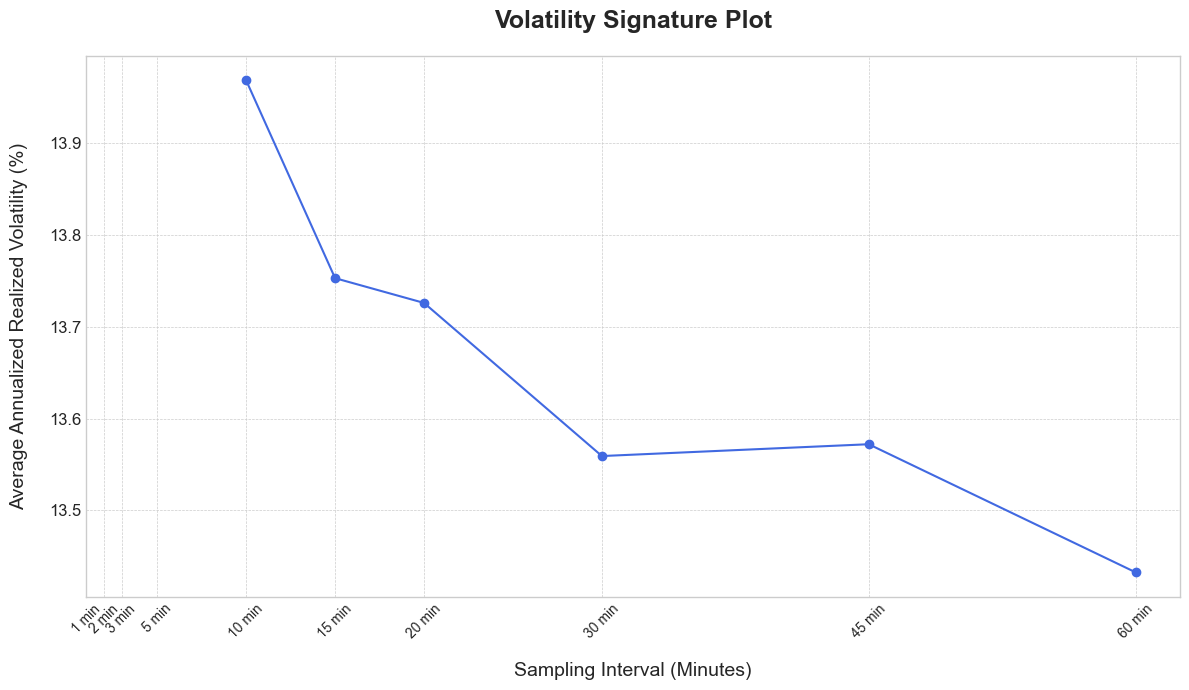

Plot generated successfully.

Based on the plot, we'll use '5min' as the chosen interval for the final calculation.
You can edit the 'best_interval' variable in the code if you prefer a different one.

Calculating final daily realized volatility using the chosen '5min' interval...


c:\Users\Jop Brouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



--- Final Daily Realized Volatility (Annualized) ---
2024-12-09   0.0644
2024-12-10   0.0635
2024-12-11   0.0564
2024-12-12   0.0642
2024-12-13   0.0751
2024-12-15   0.0204
2024-12-16   0.0560
2024-12-17   0.0750
2024-12-18   0.2204
2024-12-19   0.1703


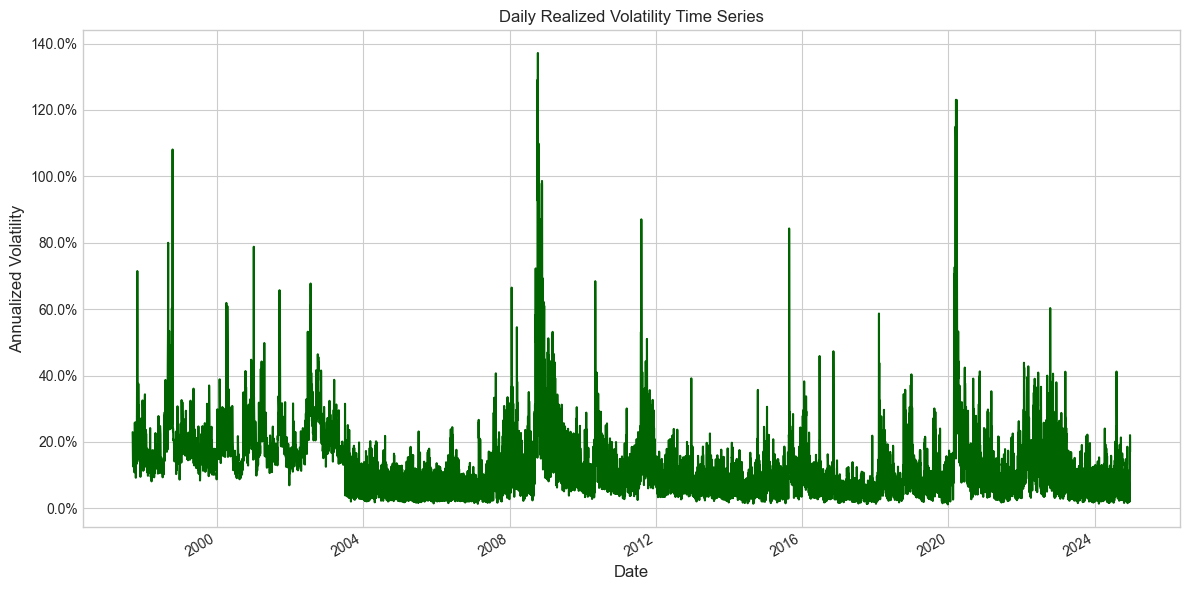

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def calculate_realized_volatility(df, freq='5min'):
    """
    Calculates the daily realized volatility from intraday data.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index and a 'close' column.
        freq (str): The sampling frequency (e.g., '1min', '5min', '15min').

    Returns:
        pd.Series: A Series of daily realized volatility, annualized.
    """
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("The DataFrame index must be a DatetimeIndex.")
        
    # Resample the close price to the desired frequency
    df_resampled = df['Close'].resample(freq).last()

    # Calculate log returns
    log_returns = np.log(df_resampled).diff().dropna()

    # Group by day and calculate the sum of squared returns
    # We use .sum() which will handle days with no trades by returning 0
    realized_variance_daily = (log_returns**2).resample('D').sum()
    
    # Filter out days with no trading activity
    realized_variance_daily = realized_variance_daily[realized_variance_daily > 0]
    
    # Annualize the volatility (sqrt of variance * sqrt of trading days)
    # 252 is a common assumption for the number of trading days in a year.
    annualization_factor = np.sqrt(252)
    realized_volatility_daily = np.sqrt(realized_variance_daily) * annualization_factor
    
    return realized_volatility_daily.dropna()

def generate_volatility_signature_plot(df, intervals_in_minutes):
    """
    Generates and displays a volatility signature plot.

    Args:
        df (pd.DataFrame): The input DataFrame with minute-level data.
        intervals_in_minutes (list): A list of integers representing the sampling
                                     intervals in minutes.
    """
    print("\nCalculating volatility for different sampling intervals...")
    avg_volatilities = []

    for interval in intervals_in_minutes:
        freq = f'{interval}min'
        daily_vol = calculate_realized_volatility(df, freq=freq)
        # Check if daily_vol is not empty before calculating mean
        if not daily_vol.empty:
            avg_vol = daily_vol.mean() * 100  # Convert to percentage
            avg_volatilities.append(avg_vol)
            print(f"  - Average volatility for {freq} interval: {avg_vol:.4f}%")
        else:
            avg_volatilities.append(np.nan) # Append NaN if no data
            print(f"  - No trading data for {freq} interval.")
            
    # --- Plotting ---
    print("\nGenerating Volatility Signature Plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(intervals_in_minutes, avg_volatilities, marker='o', linestyle='-', color='royalblue')
    
    # Formatting the plot for clarity
    ax.set_title('Volatility Signature Plot', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Sampling Interval (Minutes)', fontsize=14, labelpad=15)
    ax.set_ylabel('Average Annualized Realized Volatility (%)', fontsize=14, labelpad=15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Set x-axis ticks to match the intervals
    ax.set_xticks(intervals_in_minutes)
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d min'))
    
    # Improve readability of tick labels
    plt.xticks(rotation=45)
    plt.yticks(fontsize=12)
    
    fig.tight_layout()
    plt.show()
    print("Plot generated successfully.")


def analyze_my_futures_data(df_futures):
    """
    Main analysis function that takes a futures DataFrame and performs
    the volatility analysis.

    Args:
        df_futures (pd.DataFrame): Your DataFrame with minute-level data.
                                   It should contain 'Date', 'Time', and 'close' columns.
    """
    # --- Preprocessing Step ---
    # Create a copy to avoid SettingWithCopyWarning
    df_processed = df_futures.copy()
    
    # Combine 'Date' and 'Time' columns and set as index
    print("Preprocessing data: Combining 'Date' and 'Time' into a datetime index...")
    try:
        datetime_col = pd.to_datetime(df_processed['Date'] + ' ' + df_processed['Time'])
        df_processed.index = datetime_col
    except Exception as e:
        print(f"Error combining Date and Time columns: {e}")
        print("Please ensure 'Date' and 'Time' columns are in a format pandas can recognize.")
        return

    # Define the sampling intervals (in minutes) to test
    sampling_intervals = [1, 2, 3, 5, 10, 15, 20, 30, 45, 60]

    # Generate the signature plot to find the best interval
    generate_volatility_signature_plot(df_processed, sampling_intervals)

    # --- After analyzing the plot, choose your best interval ---
    # Manually update this value based on your analysis of the signature plot.
    best_interval = '5min' 
    print(f"\nBased on the plot, we'll use '{best_interval}' as the chosen interval for the final calculation.")
    print("You can edit the 'best_interval' variable in the code if you prefer a different one.")
    
    print(f"\nCalculating final daily realized volatility using the chosen '{best_interval}' interval...")

    final_daily_volatility = calculate_realized_volatility(df_processed, freq=best_interval)

    # Display the last 10 days of calculated volatility
    print("\n--- Final Daily Realized Volatility (Annualized) ---")
    if not final_daily_volatility.empty:
        print(final_daily_volatility.tail(10).to_string(float_format="%.4f"))
    else:
        print("No volatility data to display.")
    
    # Optional: Plot the final daily volatility time series
    if not final_daily_volatility.empty:
        fig, ax = plt.subplots(figsize=(12, 6))
        final_daily_volatility.plot(ax=ax, color='darkgreen', title='Daily Realized Volatility Time Series')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Annualized Volatility', fontsize=12)
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1))
        fig.tight_layout()
        plt.show()


# --- HOW TO USE ---
if __name__ == '__main__':
    # 1. Make sure your DataFrame `df_es` is loaded and available.
    #    It should have columns named:
    #    'Date', 'Time', 'open', 'high', 'low', 'close', 'tick_count', 'volume'.
    #
    # Example of loading your data:
    # df_es = pd.read_csv('path/to/your/futures_data.csv') 

    # 2. Once `df_es` is loaded, uncomment and run the following line:
    # analyze_my_futures_data(df_es)
    
    print("Script is ready. Please load your 'df_es' DataFrame and call 'analyze_my_futures_data(df_es)' to start.")
    # For demonstration, if a variable named `df_es` exists, we'll run the analysis.
    if 'df_es' in locals() or 'df_es' in globals():
         print("\n'df_es' detected. Running analysis...")
         analyze_my_futures_data(df_es)


Script is ready. Please load your 'df_es' DataFrame and call 'analyze_and_add_volatility(df_es)' to start.

'df_es' detected. Running analysis...
Preprocessing data: Combining 'Date' and 'Time' into a datetime index...

Calculating daily realized volatility using a '5min' sampling interval...


c:\Users\Jop Brouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Adding 'daily_realized_volatility' column to the DataFrame...

--- DataFrame with Daily Realized Volatility (Last 10 rows) ---
                           Date   Time     Open     High      Low    Close  Volume  Tick Count  daily_realized_volatility
2024-12-19 15:51:00  12/19/2024  15:51  5943.50  5943.50  5942.50  5943.50     519         146                   0.170301
2024-12-19 15:52:00  12/19/2024  15:52  5943.50  5943.75  5942.75  5943.50     263          59                   0.170301
2024-12-19 15:53:00  12/19/2024  15:53  5943.50  5943.50  5943.00  5943.25     320          78                   0.170301
2024-12-19 15:54:00  12/19/2024  15:54  5943.50  5943.50  5943.00  5943.00     585         195                   0.170301
2024-12-19 15:55:00  12/19/2024  15:55  5942.75  5943.00  5941.50  5941.75     901         144                   0.170301
2024-12-19 15:56:00  12/19/2024  15:56  5941.75  5942.00  5941.25  5941.75     318          79                   0.170301
2024-12-19 15:57:00

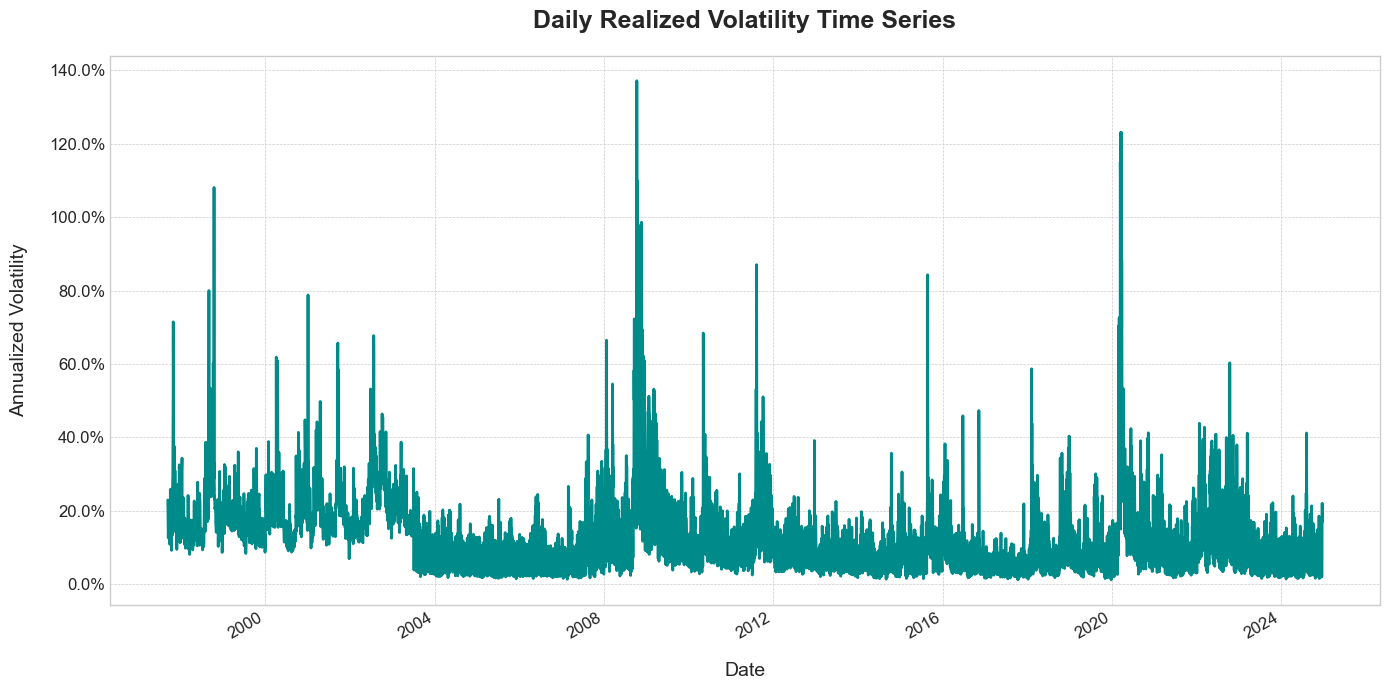

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def calculate_daily_realized_volatility(df, freq='5min', close_col='Close'):
    """
    Calculates the daily realized volatility from intraday data.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index and a close price column.
        freq (str): The sampling frequency (e.g., '1min', '5min', '15min').
        close_col (str): The name of the close price column.

    Returns:
        pd.Series: A Series of daily realized volatility, annualized.
    """
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("The DataFrame index must be a DatetimeIndex.")
        
    # Resample the close price to the desired frequency
    df_resampled = df[close_col].resample(freq).last()

    # Calculate log returns
    log_returns = np.log(df_resampled).diff().dropna()

    # Group by day and calculate the sum of squared returns
    realized_variance_daily = (log_returns**2).resample('D').sum()
    
    # Filter out days with no trading activity
    realized_variance_daily = realized_variance_daily[realized_variance_daily > 0]
    
    # Annualize the volatility (sqrt of variance * sqrt of trading days)
    # 252 is a common assumption for the number of trading days in a year.
    annualization_factor = np.sqrt(252)
    realized_volatility_daily = np.sqrt(realized_variance_daily) * annualization_factor
    
    return realized_volatility_daily.dropna()


def analyze_and_add_volatility(df_futures):
    """
    Main analysis function. It calculates daily realized volatility, adds it
    as a new column to the DataFrame, and plots the result.

    Args:
        df_futures (pd.DataFrame): Your DataFrame with minute-level data.
                                   It should contain 'Date', 'Time', and 'Close' columns.
    
    Returns:
        pd.DataFrame: The original DataFrame with the new 'daily_realized_volatility' column.
    """
    # --- 1. Preprocessing Step ---
    # Create a copy to avoid modifying the original DataFrame unexpectedly
    df_processed = df_futures.copy()
    
    # Combine 'Date' and 'Time' columns and set as index
    print("Preprocessing data: Combining 'Date' and 'Time' into a datetime index...")
    try:
        datetime_col = pd.to_datetime(df_processed['Date'] + ' ' + df_processed['Time'])
        df_processed.index = datetime_col
    except Exception as e:
        print(f"Error combining Date and Time columns: {e}")
        print("Please ensure 'Date' and 'Time' columns are in a format pandas can recognize.")
        return None

    # --- 2. Calculate Volatility ---
    # We use a 5-minute interval as a standard practice to balance capturing
    # volatility information and reducing market microstructure noise.
    # You can change this value if needed.
    sampling_interval = '5min'
    print(f"\nCalculating daily realized volatility using a '{sampling_interval}' sampling interval...")
    
    daily_volatility = calculate_daily_realized_volatility(
        df_processed, 
        freq=sampling_interval, 
        close_col='Close' # Using 'Close' with a capital C
    )

    # --- 3. Add Volatility Column to DataFrame ---
    # Map the calculated daily volatility back to the original minute-level DataFrame.
    # Each row will have the realized volatility value for its corresponding day.
    print("Adding 'daily_realized_volatility' column to the DataFrame...")
    # Normalize index to match the daily frequency of the volatility series
    df_processed['daily_realized_volatility'] = df_processed.index.normalize().map(daily_volatility)
    
    print("\n--- DataFrame with Daily Realized Volatility (Last 10 rows) ---")
    print(df_processed.tail(10).to_string())

    # --- 4. Plot the Daily Realized Volatility Time Series ---
    print("\nGenerating plot for the daily realized volatility time series...")
    # We plot the daily_volatility series directly as it's one value per day
    if not daily_volatility.empty:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(14, 7))
        
        daily_volatility.plot(ax=ax, color='darkcyan', lw=2)
        
        ax.set_title('Daily Realized Volatility Time Series', fontsize=18, fontweight='bold', pad=20)
        ax.set_xlabel('Date', fontsize=14, labelpad=15)
        ax.set_ylabel('Annualized Volatility', fontsize=14, labelpad=15)
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1))
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        
        fig.tight_layout()
        plt.show()
    else:
        print("No volatility data to plot.")
        
    return df_processed


# --- HOW TO USE ---
if __name__ == '__main__':
    # 1. Make sure your DataFrame `df_es` is loaded and available.
    #    It should have columns named:
    #    'Date', 'Time', 'open', 'high', 'low', 'Close', 'tick_count', 'volume'.
    #
    # Example of loading your data:
    # df_es = pd.read_csv('path/to/your/futures_data.csv') 

    # 2. Once `df_es` is loaded, uncomment and run the following line:
    # df_es_with_vol = analyze_and_add_volatility(df_es)
    
    print("Script is ready. Please load your 'df_es' DataFrame and call 'analyze_and_add_volatility(df_es)' to start.")
    
    # For demonstration, if a variable named `df_es` exists, we'll run the analysis.
    if 'df_es' in locals() or 'df_es' in globals():
        print("\n'df_es' detected. Running analysis...")
        df_es_with_vol = analyze_and_add_volatility(df_es)

